In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [14]:
aexdf = pd.read_csv("data_aex.csv", sep=";")
aexdf["Date"] = pd.to_datetime(aexdf["Date"])
aexdf['YearMonth'] = aexdf['Date'].dt.to_period('M')

aexdf = aexdf.sort_values(by=["ticker"])

aexdf["Monthly_Return"] = aexdf.groupby("ticker")["Adj Close"].pct_change()
aexdf["Momentum"] = aexdf.groupby("ticker")["Adj Close"].shift(1) / aexdf.groupby("ticker")["Adj Close"].shift(12) - 1

aexdf["Zero_Return"] = (aexdf["Monthly_Return"] == 0).astype(int)
aexdf["Zero_Streak"] = aexdf.groupby("ticker")["Zero_Return"].cumsum() * aexdf["Zero_Return"]
tickers_with_zero_returns = aexdf[aexdf["Zero_Streak"] > 1]["ticker"].unique()
print(tickers_with_zero_returns)

#filter wolters kluwer
print(aexdf[aexdf["Zero_Streak"] == 2])
filtered_df = aexdf[aexdf["Zero_Streak"] <= 1].drop(columns=["Zero_Return", "Zero_Streak"])
filtered_df = filtered_df.reset_index(drop=True)

# print(filtered_df[filtered_df["Zero_Streak"] > 1]["ticker"].unique())
print(aexdf[["ticker", "Date", "Adj Close", "Close", "Open"]][aexdf["Close"] == aexdf["Open"]])

# print(aexdf[["Date", "ticker", "Adj Close", "Monthly_Return", "Momentum"]].head(20))

[]
Empty DataFrame
Columns: [Date, Adj Close, Close, High, Low, Open, Volume, ticker, YearMonth, Monthly_Return, Momentum, Zero_Return, Zero_Streak]
Index: []
        ticker       Date  Adj Close      Close       Open
43      ABN.AS 2019-06-01  11.786198  18.815001  18.815001
663    AKZA.AS 2018-11-01  59.374126  83.362488  83.362488
1543   HEIA.AS 2018-04-01  77.088051  87.300003  87.300003
3079  SHELL.AS 2013-03-01  12.994920  25.190001  25.190001


2025-02
High Momentum Tickers: ['PHIA.AS', 'PRX.AS', 'INGA.AS', 'AD.AS', 'UNA.AS', 'WKL.AS', 'REN.AS', 'AGN.AS']
Low Momentum Tickers: ['BESI.AS', 'HEIA.AS', 'ASML.AS', 'AKZA.AS', 'RAND.AS', 'EXO.AS', 'UMG.AS', 'ASM.AS']


/tmp/ipykernel_1066/2723115106.py:69: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  plt.gca().set_xticks(mdates.date2num(momentum_df['YearMonth'].dt.to_pydatetime())[::12])  # Show one tick per year


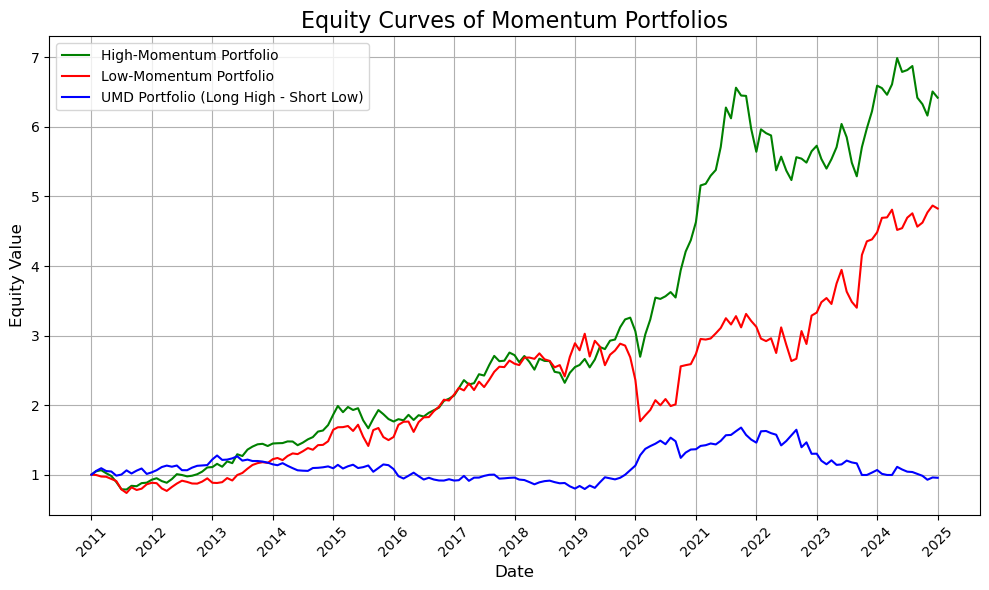

In [ ]:
aexdf['Date'] = pd.to_datetime(aexdf['Date'])
aexdf['YearMonth'] = aexdf['Date'].dt.to_period('M')

aexdf = aexdf.sort_values(by=['ticker', 'Date'])

aexdf['Monthly_Return'] = aexdf.groupby('ticker')['Adj Close'].pct_change()

aexdf['Momentum'] = aexdf.groupby('ticker')['Adj Close'].shift(1) / aexdf.groupby('ticker')['Adj Close'].shift(12) - 1

aexdf = aexdf[aexdf['YearMonth'] >= '2011-02']

portfolio_returns = []

last_month = aexdf['YearMonth'].max()
print(last_month)
for month, group in aexdf.groupby('YearMonth'):
    group = group.dropna(subset=['Momentum']) # Drop NaNs 

    high_mom = group.nlargest(8, 'Momentum')
    low_mom = group.nsmallest(8, 'Momentum')

    if month == last_month:
        print("High Momentum Tickers:", high_mom['ticker'].tolist())
        print("Low Momentum Tickers:", low_mom['ticker'].tolist())

    high_return = high_mom['Monthly_Return'].mean()
    low_return = low_mom['Monthly_Return'].mean()
    umd_return = high_return - low_return

    portfolio_returns.append([month, high_return, low_return, umd_return])

momentum_df = pd.DataFrame(portfolio_returns, columns=['YearMonth', 'High_Momentum_Return', 'Low_Momentum_Return', 'UMD_Return'])

momentum_df['YearMonth'] = momentum_df['YearMonth'].astype(str)

# print(momentum_df.head(20))
momentum_df['YearMonth'] = pd.to_datetime(momentum_df['YearMonth'], errors='coerce')

# Compute the equity curve (cumulative product of 1 + portfolio return)
momentum_df['High_Momentum_Equity'] = (1 + momentum_df['High_Momentum_Return']).cumprod()
momentum_df['Low_Momentum_Equity'] = (1 + momentum_df['Low_Momentum_Return']).cumprod()
momentum_df['UMD_Equity'] = (1 + momentum_df['UMD_Return']).cumprod()

# Normalize the equity curves to 1 in January 2011 (assuming the first row corresponds to that date)
momentum_df.iloc[0, momentum_df.columns.get_loc('High_Momentum_Equity')] = 1
momentum_df.iloc[0, momentum_df.columns.get_loc('Low_Momentum_Equity')] = 1
momentum_df.iloc[0, momentum_df.columns.get_loc('UMD_Equity')] = 1

# Plot the equity curves
plt.figure(figsize=(10, 6))
plt.plot(momentum_df['YearMonth'], momentum_df['High_Momentum_Equity'], label='High-Momentum Portfolio', color='green')
plt.plot(momentum_df['YearMonth'], momentum_df['Low_Momentum_Equity'], label='Low-Momentum Portfolio', color='red')
plt.plot(momentum_df['YearMonth'], momentum_df['UMD_Equity'], label='UMD Portfolio (Long High - Short Low)', color='blue')

# Formatting the plot
plt.title('Equity Curves of Momentum Portfolios', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Equity Value', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to yearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the ticks as years

plt.gca().set_xticks(mdates.date2num(momentum_df['YearMonth'].dt.to_pydatetime())[::12])  # Show one tick per year
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
high_momentum_mean = momentum_df['High_Momentum_Return'].mean()
high_momentum_std = momentum_df['High_Momentum_Return'].std()

low_momentum_mean = momentum_df['Low_Momentum_Return'].mean()
low_momentum_std = momentum_df['Low_Momentum_Return'].std()

umd_mean = momentum_df['UMD_Return'].mean()
umd_std = momentum_df['UMD_Return'].std()

print(high_momentum_std, low_momentum_std, umd_std)

high_momentum_sharpe = high_momentum_mean / high_momentum_std
low_momentum_sharpe = low_momentum_mean / low_momentum_std
umd_sharpe = umd_mean / umd_std

print(f"High-Momentum Portfolio Sharpe Ratio: {high_momentum_sharpe:.4f}")
print(f"Low-Momentum Portfolio Sharpe Ratio: {low_momentum_sharpe:.4f}")
print(f"UMD Portfolio Sharpe Ratio: {umd_sharpe:.4f}")

0.04557766453118402 0.06205004115921073 0.04676916448607752
High-Momentum Portfolio Sharpe Ratio: 0.2653
Low-Momentum Portfolio Sharpe Ratio: 0.1814
UMD Portfolio Sharpe Ratio: 0.0178


In [12]:
msci_df = pd.read_csv("./msci.csv")
msci_df = msci_df.drop(columns=["_DMIEU0D-volume"])  
msci_df['DateMSCI'] = pd.to_datetime(msci_df['Date']) 
msci_df['DateMSCI'] = msci_df['DateMSCI'].apply(lambda x: x.replace(day=1))
# print(msci_df['DateMSCI'].head(), momentum_df['YearMonth'].head())
msci_df['ReturnMSCI'] = msci_df['_DMIEU0D-close'].pct_change()

momentum_df = momentum_df.merge(msci_df[['DateMSCI','ReturnMSCI']], left_on='YearMonth', right_on='DateMSCI', how='left')

# momentum_df.head()
momentum_df['Constant'] = 1

In [13]:
X_high = momentum_df[['Constant', 'ReturnMSCI']]
y_high = momentum_df['High_Momentum_Return'] 
model_high = sm.OLS(y_high, X_high).fit()
y_low = momentum_df['Low_Momentum_Return'] 
model_low = sm.OLS(y_low, X_high).fit()
y_umd = momentum_df['UMD_Return'] 
model_umd = sm.OLS(y_umd, X_high).fit()

print("High-Momentum Portfolio Regression Results:")
print(model_high.summary())
print("\nLow-Momentum Portfolio Regression Results:")
print(model_low.summary())
print("\nUMD Portfolio Regression Results:")
print(model_umd.summary())

high_momentum_alpha, high_momentum_beta = model_high.params['Constant'], model_high.params['ReturnMSCI']
low_momentum_alpha, low_momentum_beta = model_low.params['Constant'], model_low.params['ReturnMSCI']
umd_alpha, umd_beta = model_umd.params['Constant'], model_umd.params['ReturnMSCI']

print("\nAlpha and Beta values for each portfolio:")
print(f"High-Momentum Portfolio: Alpha = {high_momentum_alpha:.4f}, Beta = {high_momentum_beta:.4f}")
print(f"Low-Momentum Portfolio: Alpha = {low_momentum_alpha:.4f}, Beta = {low_momentum_beta:.4f}")
print(f"UMD Portfolio: Alpha = {umd_alpha:.4f}, Beta = {umd_beta:.4f}")

High-Momentum Portfolio Regression Results:
                             OLS Regression Results                             
Dep. Variable:     High_Momentum_Return   R-squared:                       0.417
Model:                              OLS   Adj. R-squared:                  0.413
Method:                   Least Squares   F-statistic:                     119.4
Date:                  Thu, 20 Mar 2025   Prob (F-statistic):           2.60e-21
Time:                          12:46:23   Log-Likelihood:                 328.21
No. Observations:                   169   AIC:                            -652.4
Df Residuals:                       167   BIC:                            -646.2
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------